<a href="https://colab.research.google.com/github/SkAndMl/AI6121-Computer-Vision/blob/main/Assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import median_filter

# Sobel filter for preprocessing
def sobel_filter(image):
    """Apply Sobel filtering to the input image to enhance edges."""
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])
    height, width = image.shape
    sobel_filtered_image = np.zeros_like(image, dtype=np.float32)

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            region = image[y - 1:y + 2, x - 1:x + 2]
            gx = np.sum(sobel_x * region)
            gy = np.sum(sobel_y * region)
            sobel_filtered_image[y, x] = np.sqrt(gx ** 2 + gy ** 2)

    sobel_filtered_image = (sobel_filtered_image / np.max(sobel_filtered_image)) * 255
    return sobel_filtered_image

# SSD cost function
def ssd(block1, block2):
    return np.sum((block1 - block2) ** 2)

# SAD cost function
def sad(block1, block2):
    return np.sum(np.abs(block1 - block2))

# NCC cost function
def ncc(block1, block2):
    block1_mean = np.mean(block1)
    block2_mean = np.mean(block2)
    numerator = np.sum((block1 - block1_mean) * (block2 - block2_mean))
    denominator = np.sqrt(np.sum((block1 - block1_mean) ** 2) * np.sum((block2 - block2_mean) ** 2))
    return -numerator / denominator if denominator != 0 else float('inf')

# Disparity computation
def compute_disparity(source_img, target_img, direction="left", block_size=5, max_disparity_search=64, cost_function="ssd"):
    height, width = source_img.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)

    half_block = block_size // 2

    # Select cost function
    cost_func = {"ssd": ssd, "sad": sad, "ncc": ncc}[cost_function]

    for y in range(half_block, height - half_block):
        for x in range(half_block, width - half_block):
            best_match = float('inf')
            best_disparity = 0
            source_block = source_img[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            if direction == "left":
                start = max(half_block, x - max_disparity_search)
                end = x
            else:
                start = x
                end = min(width - half_block, x + max_disparity_search)

            for d in range(start, end):
                target_block = target_img[y - half_block:y + half_block + 1, d - half_block:d + half_block + 1]
                cost = cost_func(source_block, target_block)

                if cost < best_match:
                    best_match = cost
                    best_disparity = np.abs(x - d)

            disparity_map[y, x] = best_disparity

    return disparity_map

# Consistency check for disparity
def left_right_consistency_check(left_disparity, right_disparity, threshold=1):
    height, width = left_disparity.shape
    final_disparity = np.copy(left_disparity)

    for y in range(height):
        for x in range(width):
            d = left_disparity[y, x]
            if x - int(d) >= 0 and abs(d - right_disparity[y, x - int(d)]) > threshold:
                final_disparity[y, x] = 0  # Mark as invalid

    return final_disparity

# Preprocessing with Sobel filtering
def preprocess(img):
    normalized_image = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    filtered_image = sobel_filter(normalized_image)
    return filtered_image

# Final disparity map with consistency check
def disparity_map(left_img, right_img, block_size=5, max_disparity_search=64, cost_function="ssd", do_preprocess=True, do_lr_check=True):
    if do_preprocess:
        left_img, right_img = preprocess(left_img), preprocess(right_img)

    left_disparity = compute_disparity(left_img, right_img, "left", block_size, max_disparity_search, cost_function)
    if not do_lr_check: return left_disparity
    right_disparity = compute_disparity(right_img, left_img, "right", block_size, max_disparity_search, cost_function)

    final_disparity = left_right_consistency_check(left_disparity, right_disparity)
    final_disparity = median_filter(final_disparity, size=3)
    return final_disparity

# Load image
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(image, dtype=np.float32)


In [2]:
left_img = load_image("/content/corridorl.jpg")
right_img = load_image("/content/corridorr.jpg")

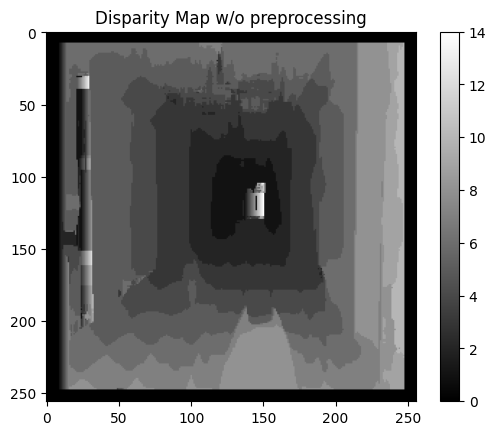

In [3]:
disparity = disparity_map(left_img, right_img, block_size=16, max_disparity_search=64, cost_function="sad", do_preprocess=False, do_lr_check=False)

plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title("Disparity Map w/o preprocessing")
plt.savefig("no_preprocess.png", dpi=300)
plt.show()

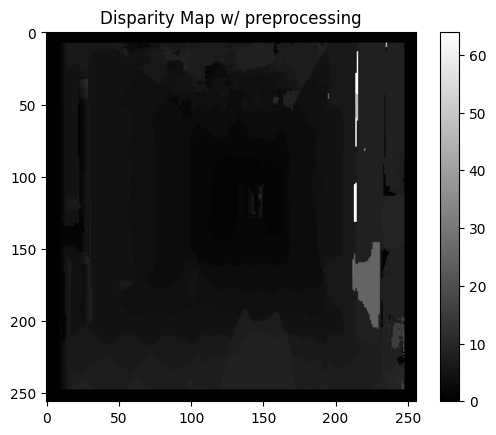

In [4]:
disparity = disparity_map(left_img, right_img, block_size=16, max_disparity_search=64, cost_function="sad", do_lr_check=False)

plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title("Disparity Map w/ preprocessing")
plt.savefig("with_preprocess.png", dpi=300)
plt.show()

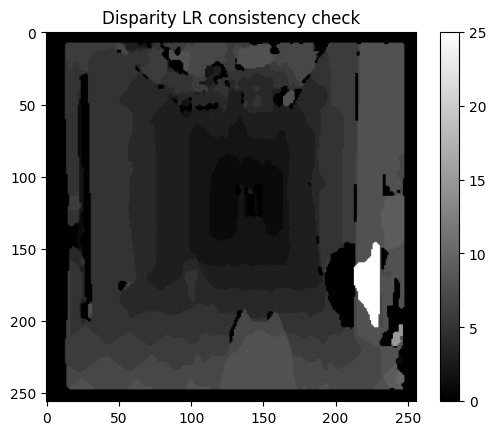

In [5]:
disparity = disparity_map(left_img, right_img, block_size=16, max_disparity_search=64, cost_function="sad", do_lr_check=True)

plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title("Disparity LR consistency check")
plt.savefig("with_lr_check.png", dpi=300)
plt.show()

In [6]:
from typing import List

def plot_param_matrix(block_sizes: List[int], search_widths: List[int], left_img_path: str, right_img_path: str, cost_function="sad", save_fig=None):
    """Plots a matrix of disparity maps for different block sizes and max_disparity_search values."""
    # Load the left and right images
    left_img = load_image(left_img_path)
    right_img = load_image(right_img_path)

    # Number of rows and columns for subplots
    rows = len(block_sizes)
    cols = len(search_widths)

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))
    fig.suptitle('Disparity Maps for Different Block Sizes and Search Widths', fontsize=14, y=1.02)

    for i, block_size in enumerate(block_sizes):
        for j, max_disparity_search in enumerate(search_widths):
            # Compute the disparity map for the current parameters
            disparity = disparity_map(left_img, right_img, block_size=block_size, max_disparity_search=max_disparity_search, cost_function=cost_function)

            # Plot the disparity map in the corresponding subplot
            ax = axes[i, j]
            im = ax.imshow(disparity, cmap='gray')
            ax.set_title(f"Block Size: {block_size}, Search Width: {max_disparity_search}", fontsize=10)
            ax.axis('off')

    # Adjust layout and add colorbar
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Reduce top margin for suptitle
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    if save_fig:
        fig.savefig(save_fig, bbox_inches='tight', dpi=300)
    plt.show()

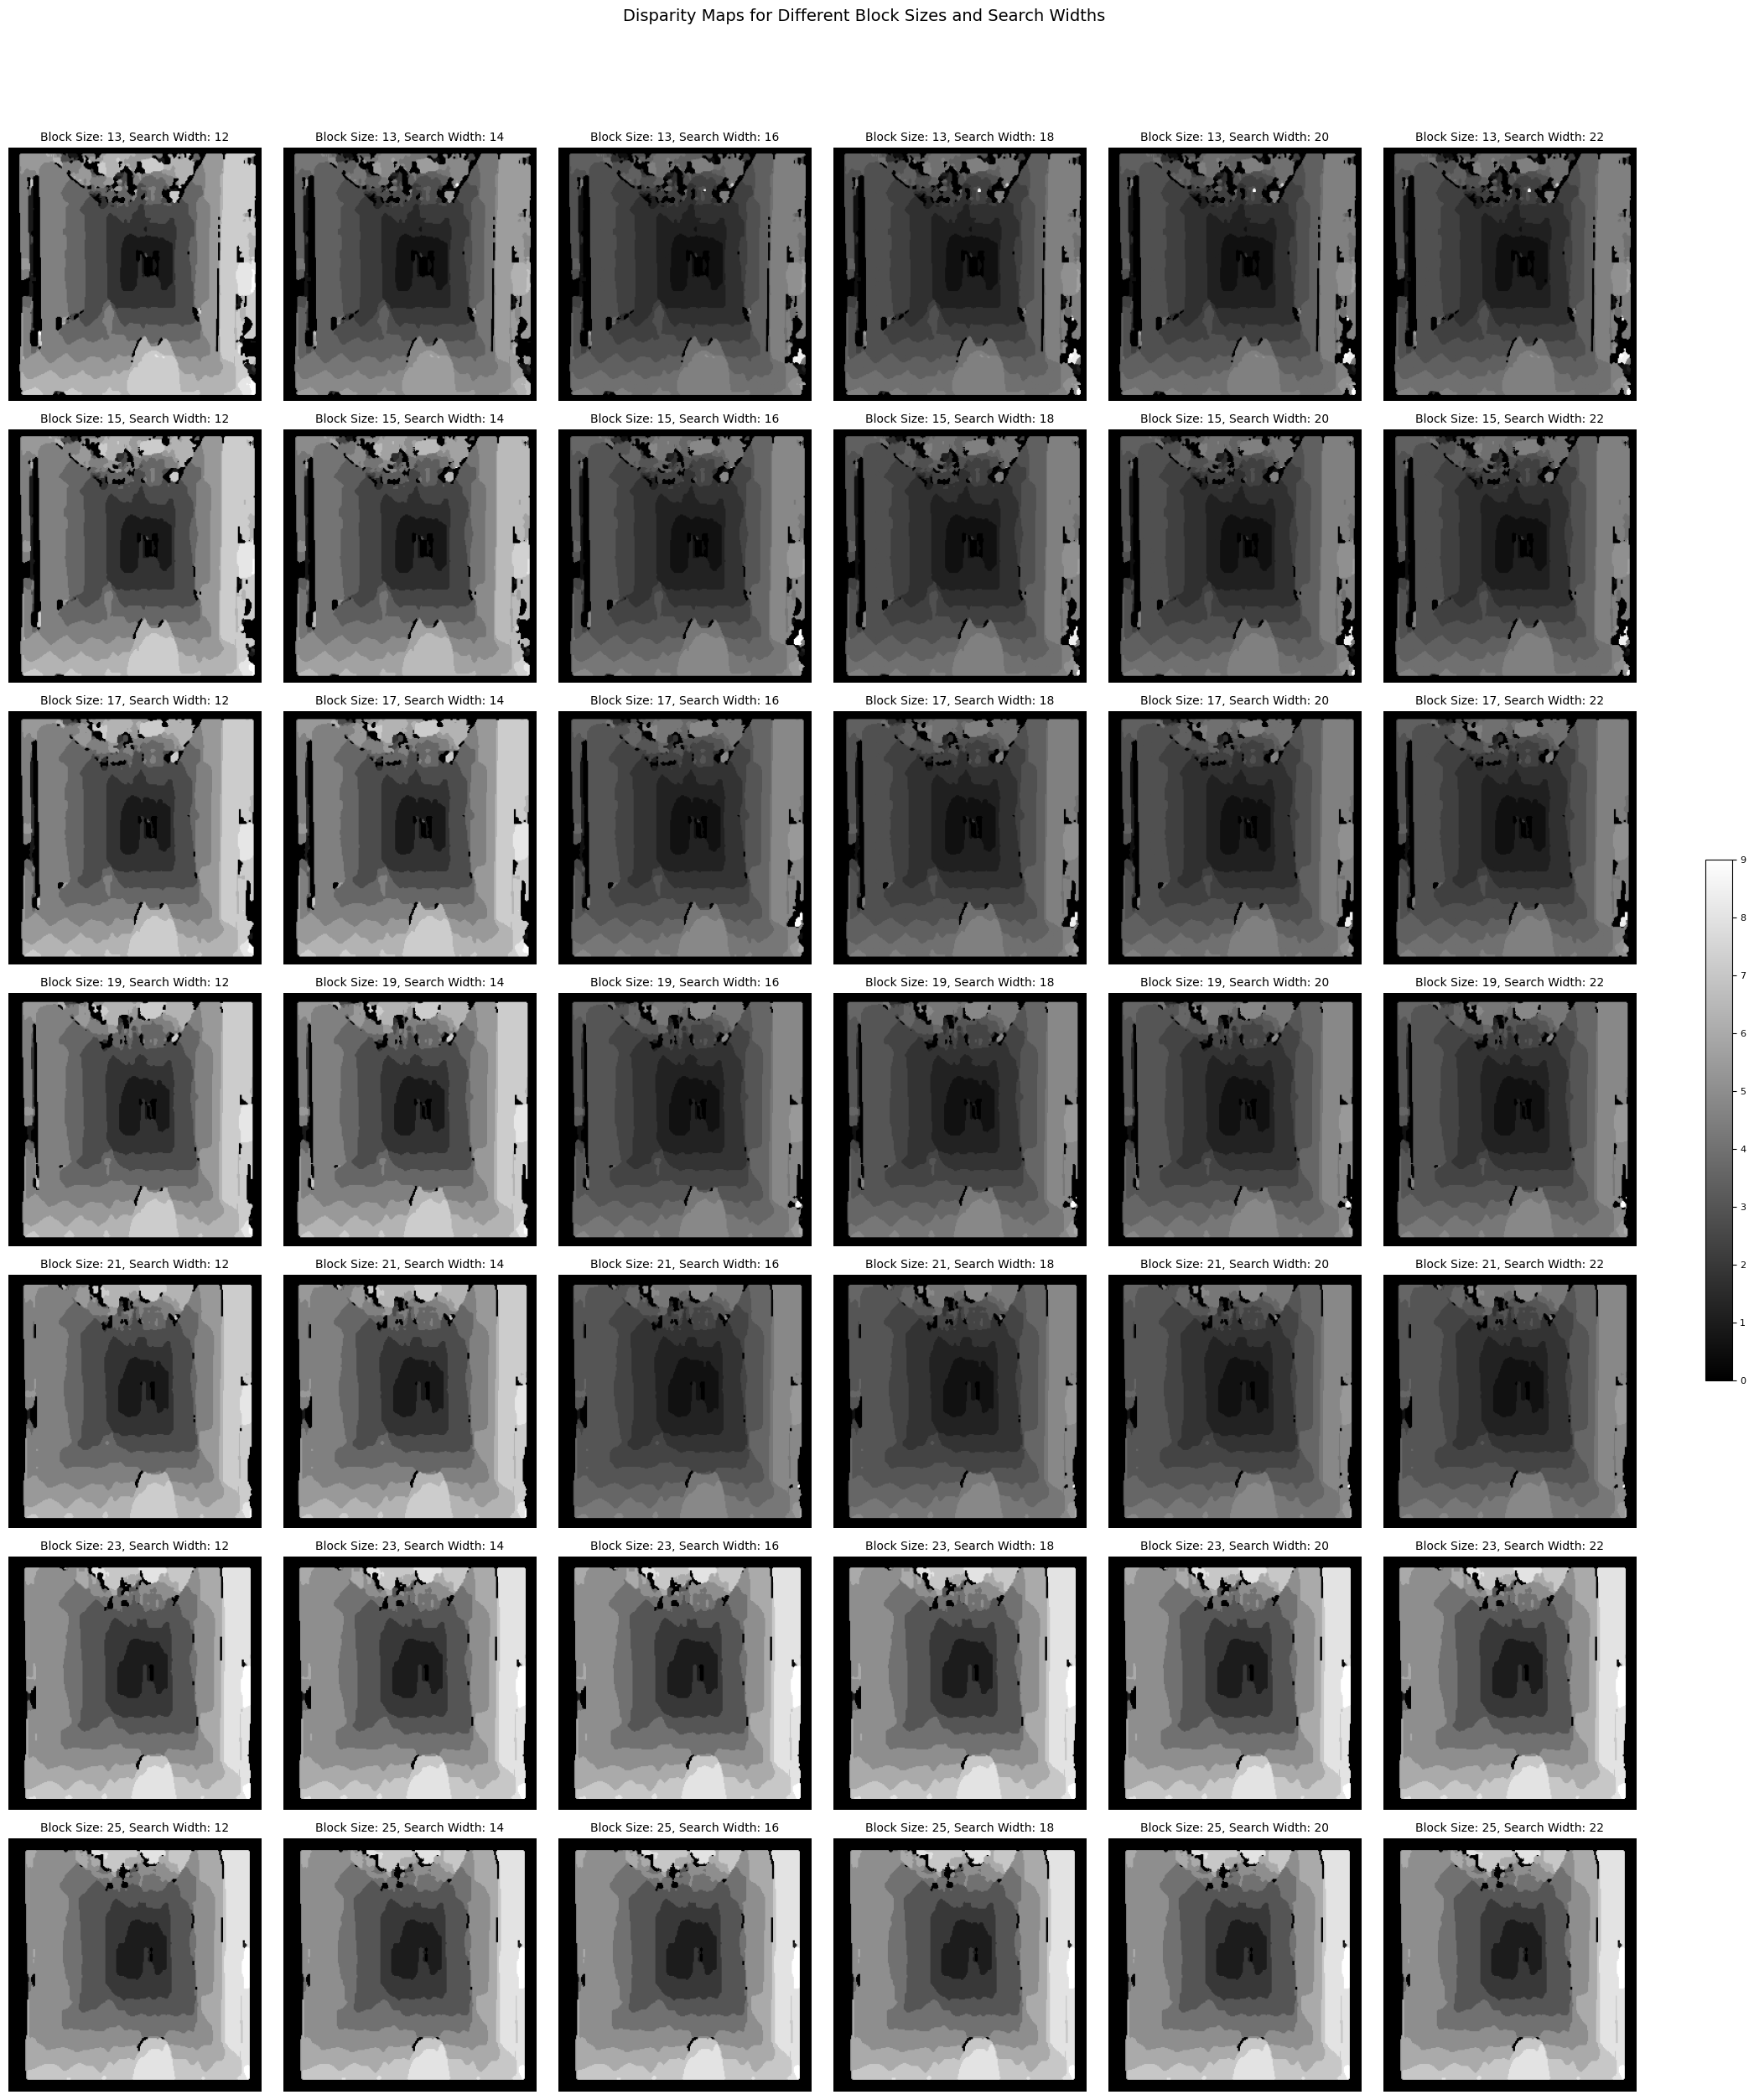

In [7]:
plot_param_matrix(
    block_sizes=list(range(13, 27, 2)),
    search_widths=list(range(12, 23, 2)),
    left_img_path="/content/corridorl.jpg",
    right_img_path="/content/corridorr.jpg",
    cost_function="sad",
    save_fig="param_matrix_corridor.png"
)

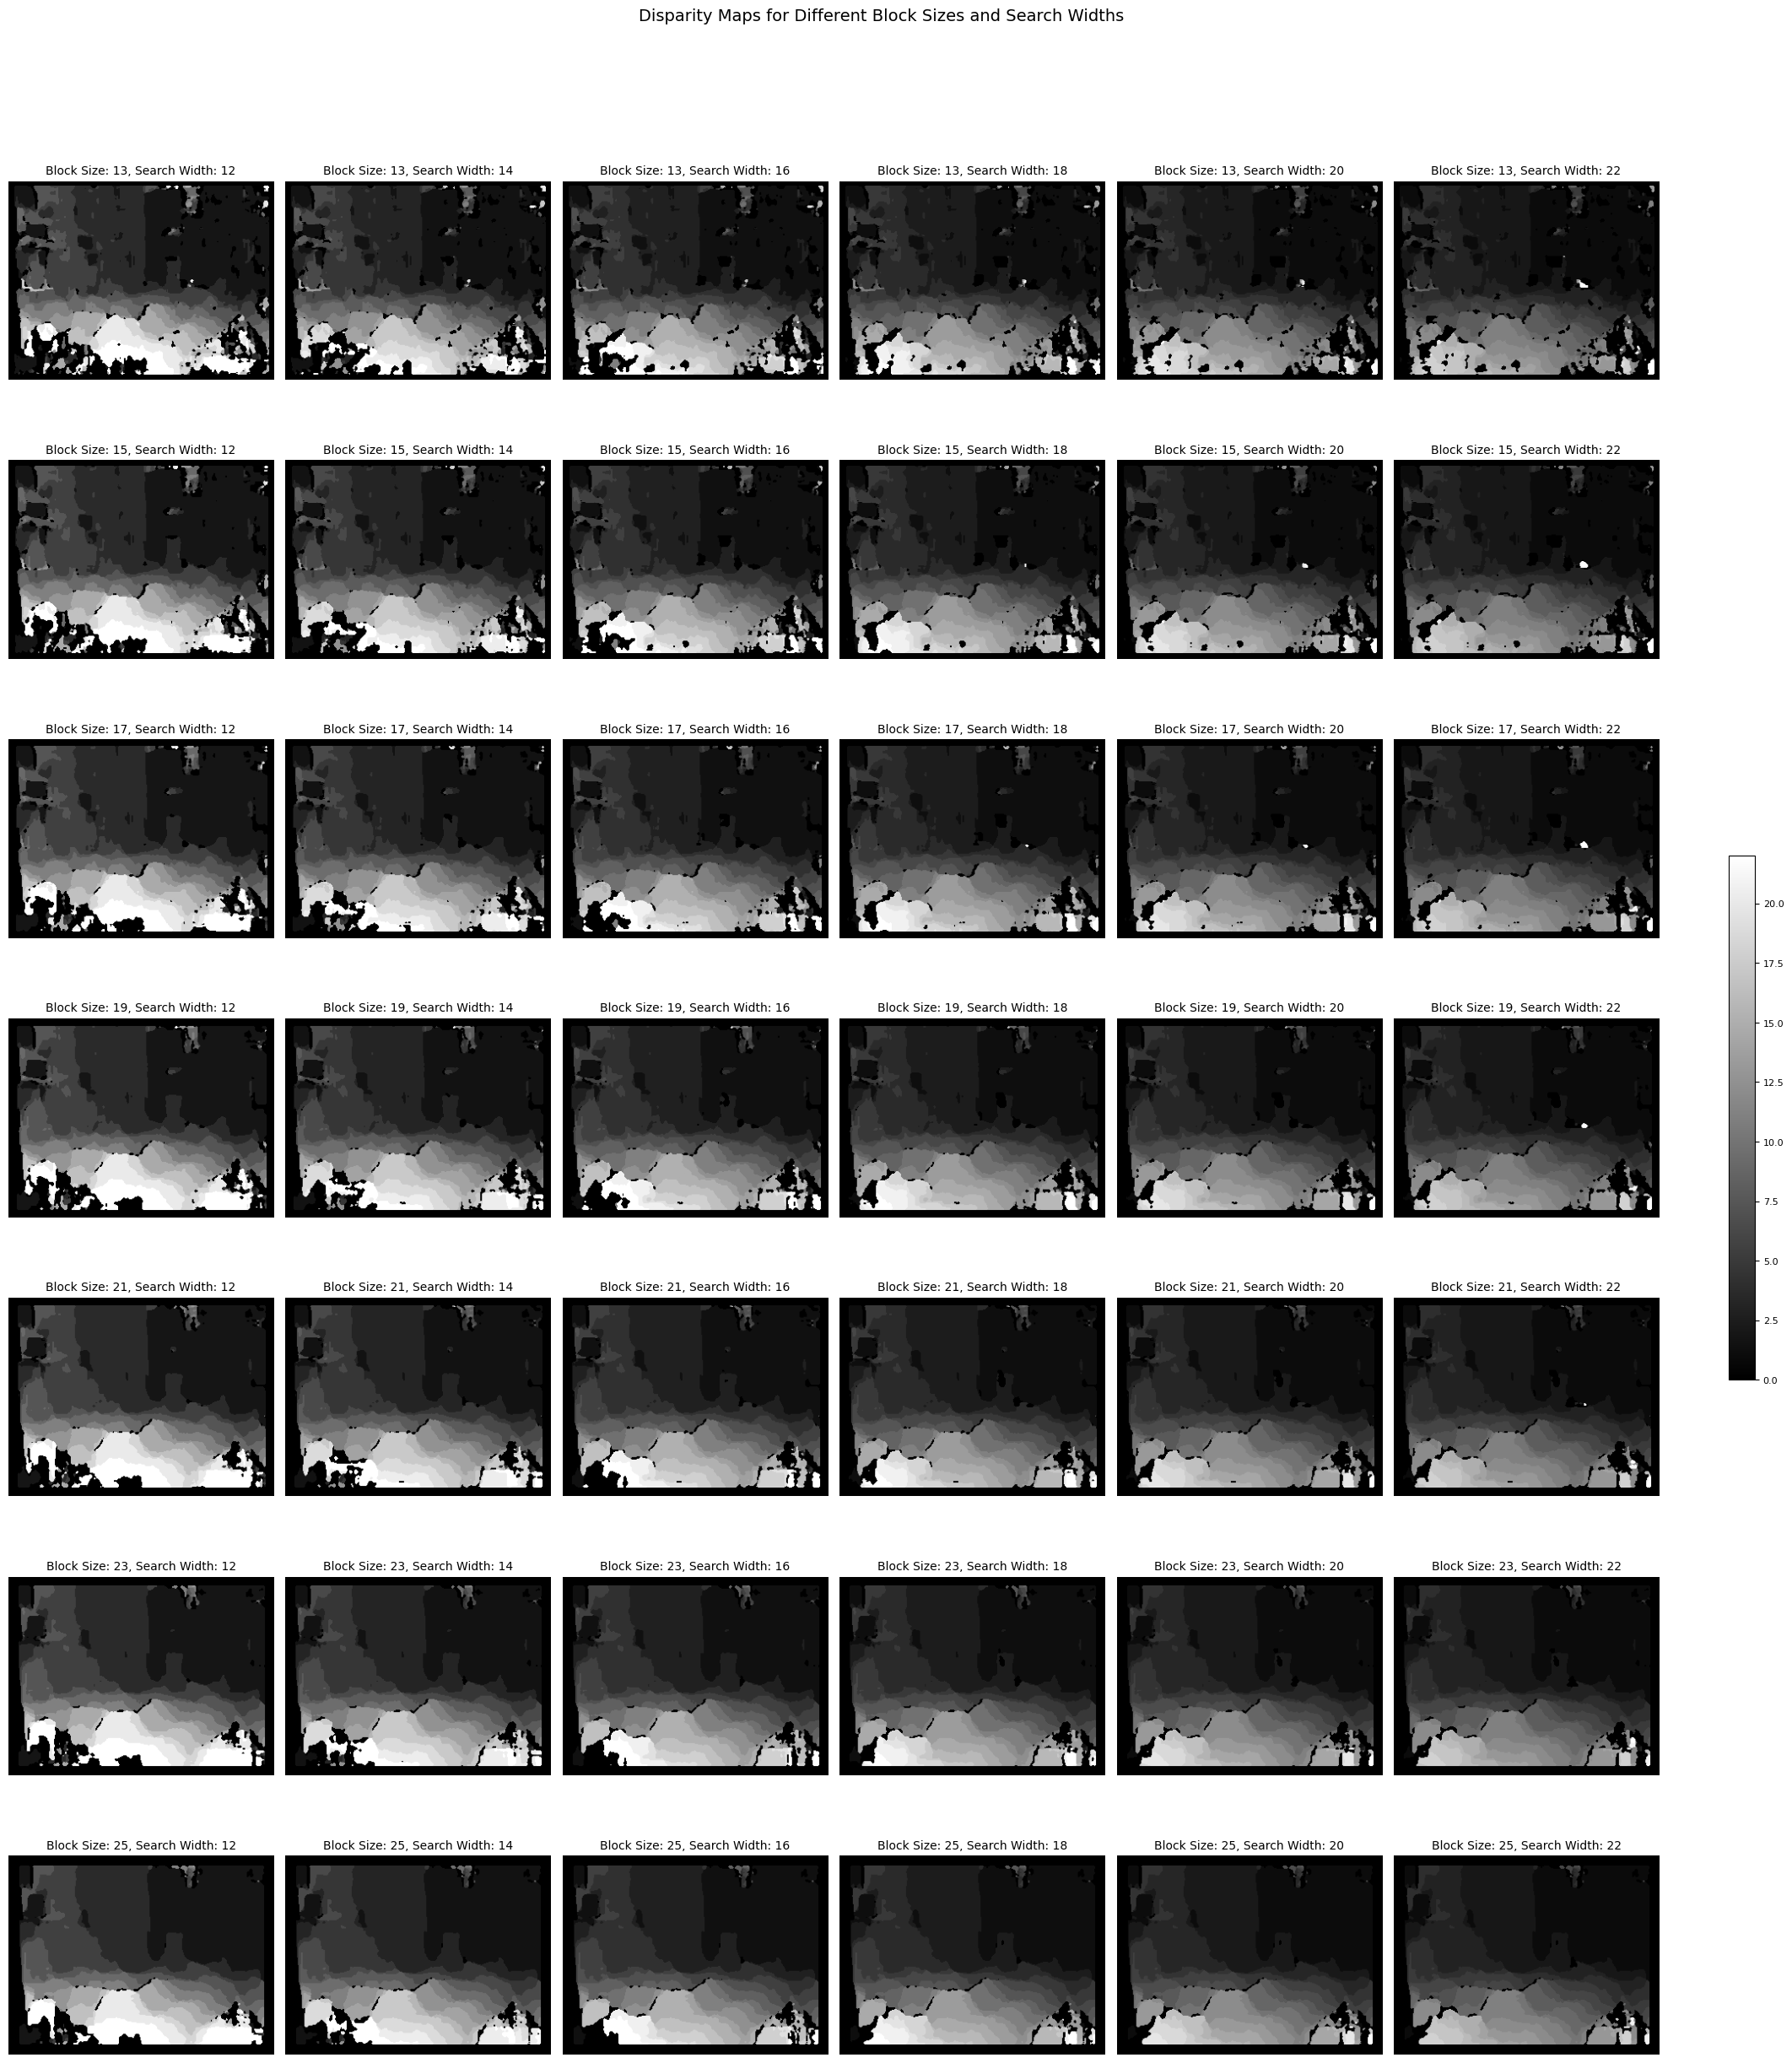

In [8]:
plot_param_matrix(
    block_sizes=list(range(13, 27, 2)),
    search_widths=list(range(12, 23, 2)),
    left_img_path="/content/triclopsi2l.jpg",
    right_img_path="/content/triclopsi2r.jpg",
    cost_function="sad",
    save_fig="param_matrix_triclops.png"
)

In [9]:
# Plotting function for comparing cost functions
def plot_cost_function_comparison(block_sizes, left_img_path, right_img_path, search_width=32, save_fig=None):
    """Plots a comparison of SSD, SAD, and NCC for different block sizes."""
    left_img = load_image(left_img_path)
    right_img = load_image(right_img_path)

    cost_functions = ["ssd", "sad", "ncc"]
    rows = len(cost_functions)
    cols = len(block_sizes)

    fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))
    fig.suptitle('Comparison of Cost Functions (SSD, SAD, NCC) with Different Block Sizes', fontsize=14, y=1.02)

    for i, cost_function in enumerate(cost_functions):
        for j, block_size in enumerate(block_sizes):
            disparity = disparity_map(left_img, right_img, block_size=block_size, max_disparity_search=search_width, cost_function=cost_function)
            ax = axes[i, j]
            im = ax.imshow(disparity, cmap='gray')
            ax.set_title(f"Block Size: {block_size}, {cost_function.upper()}", fontsize=10)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.04)

    if save_fig:
        fig.savefig(save_fig, bbox_inches='tight', dpi=300)
    plt.show()

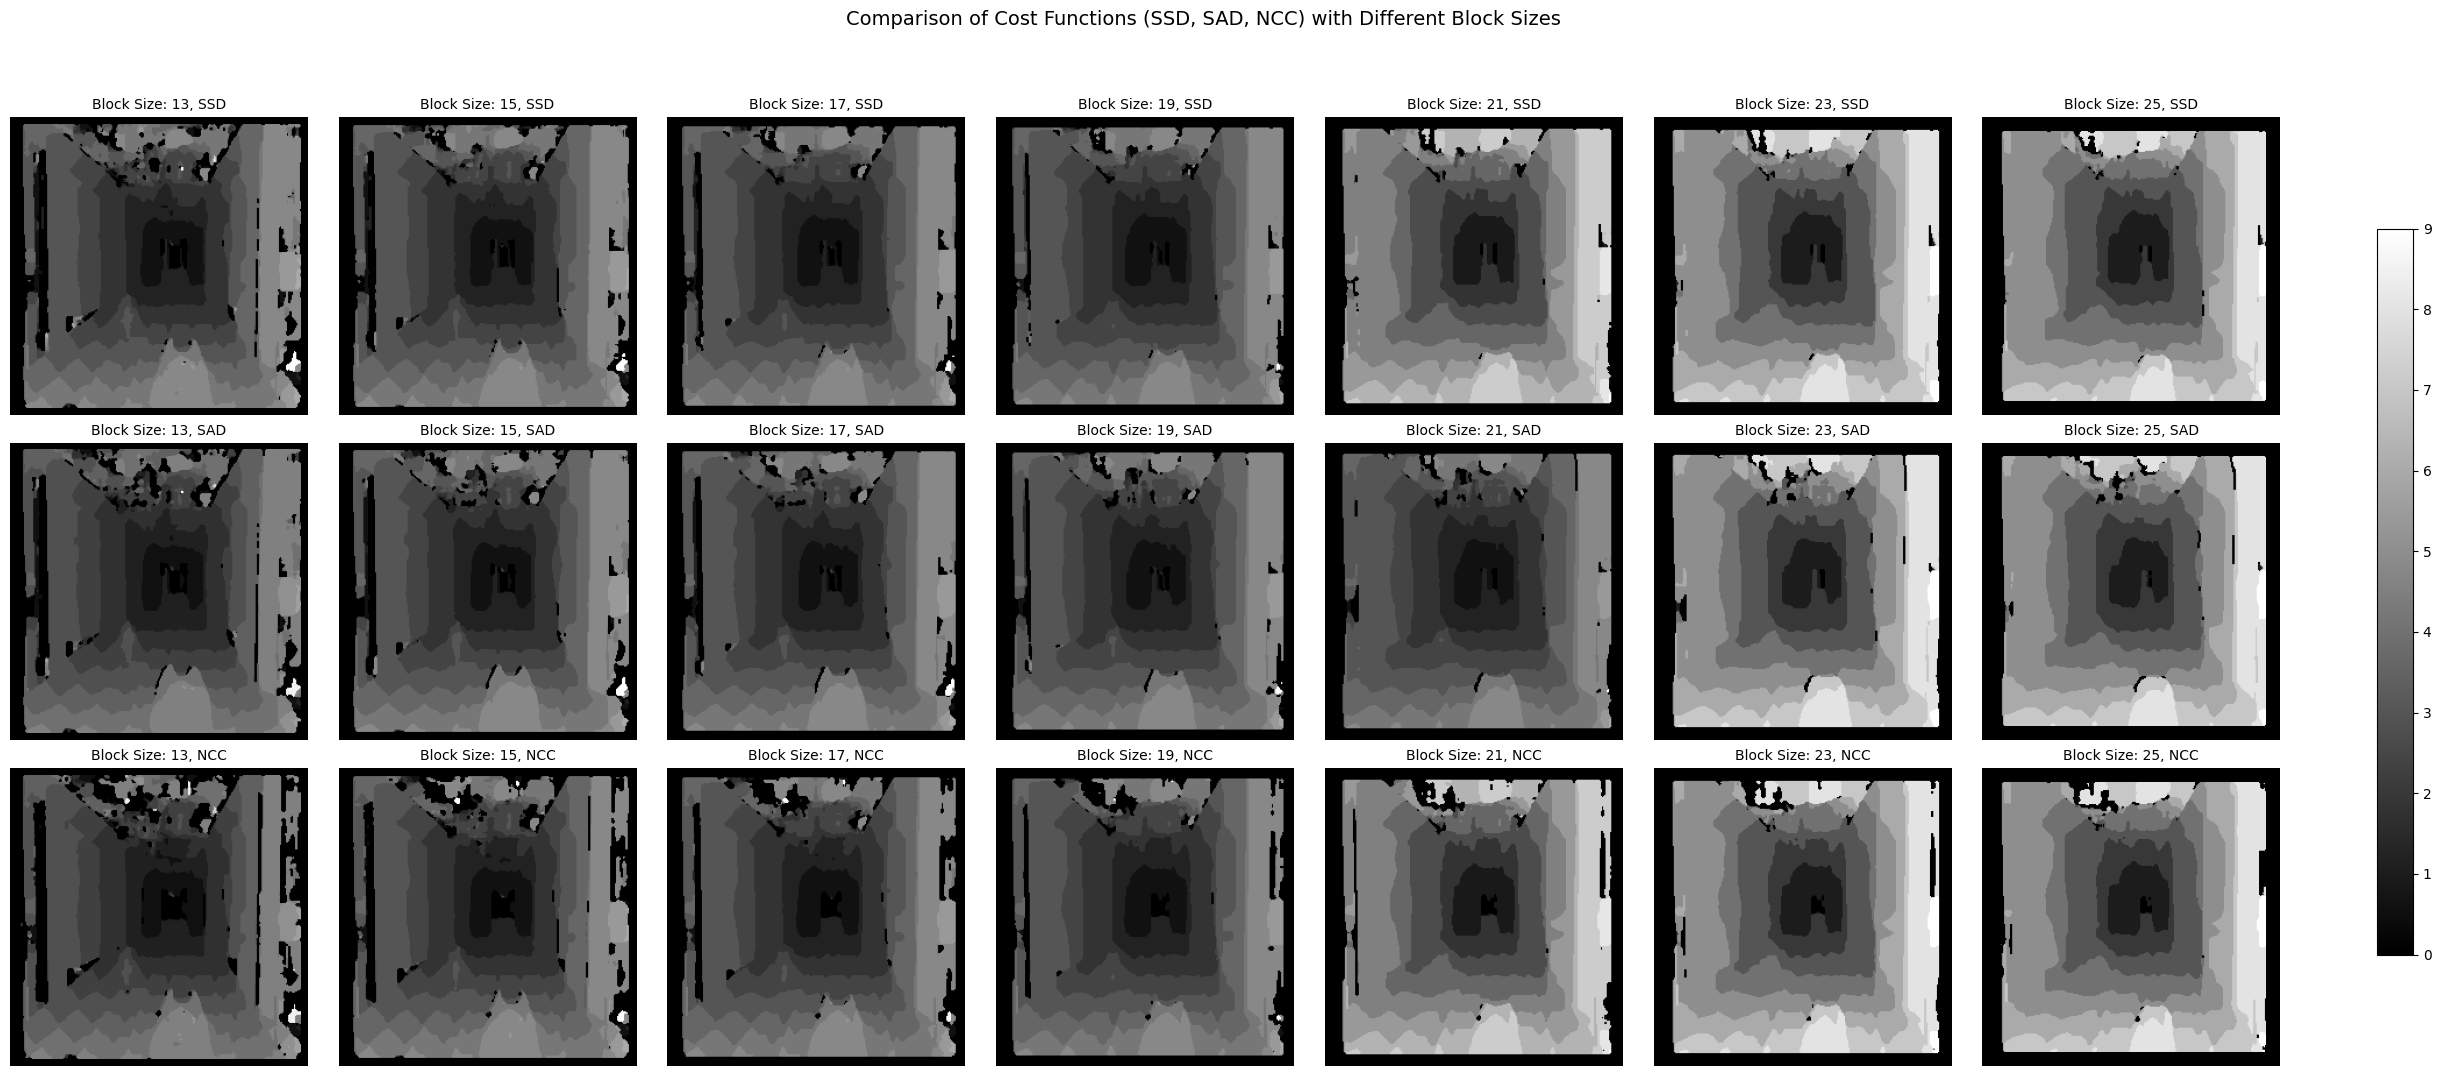

In [10]:
plot_cost_function_comparison(
    block_sizes=list(range(13, 27, 2)),
    left_img_path="/content/corridorl.jpg",
    right_img_path="/content/corridorr.jpg",
    search_width=16,
    save_fig="cost_functions_corridor.png"
)

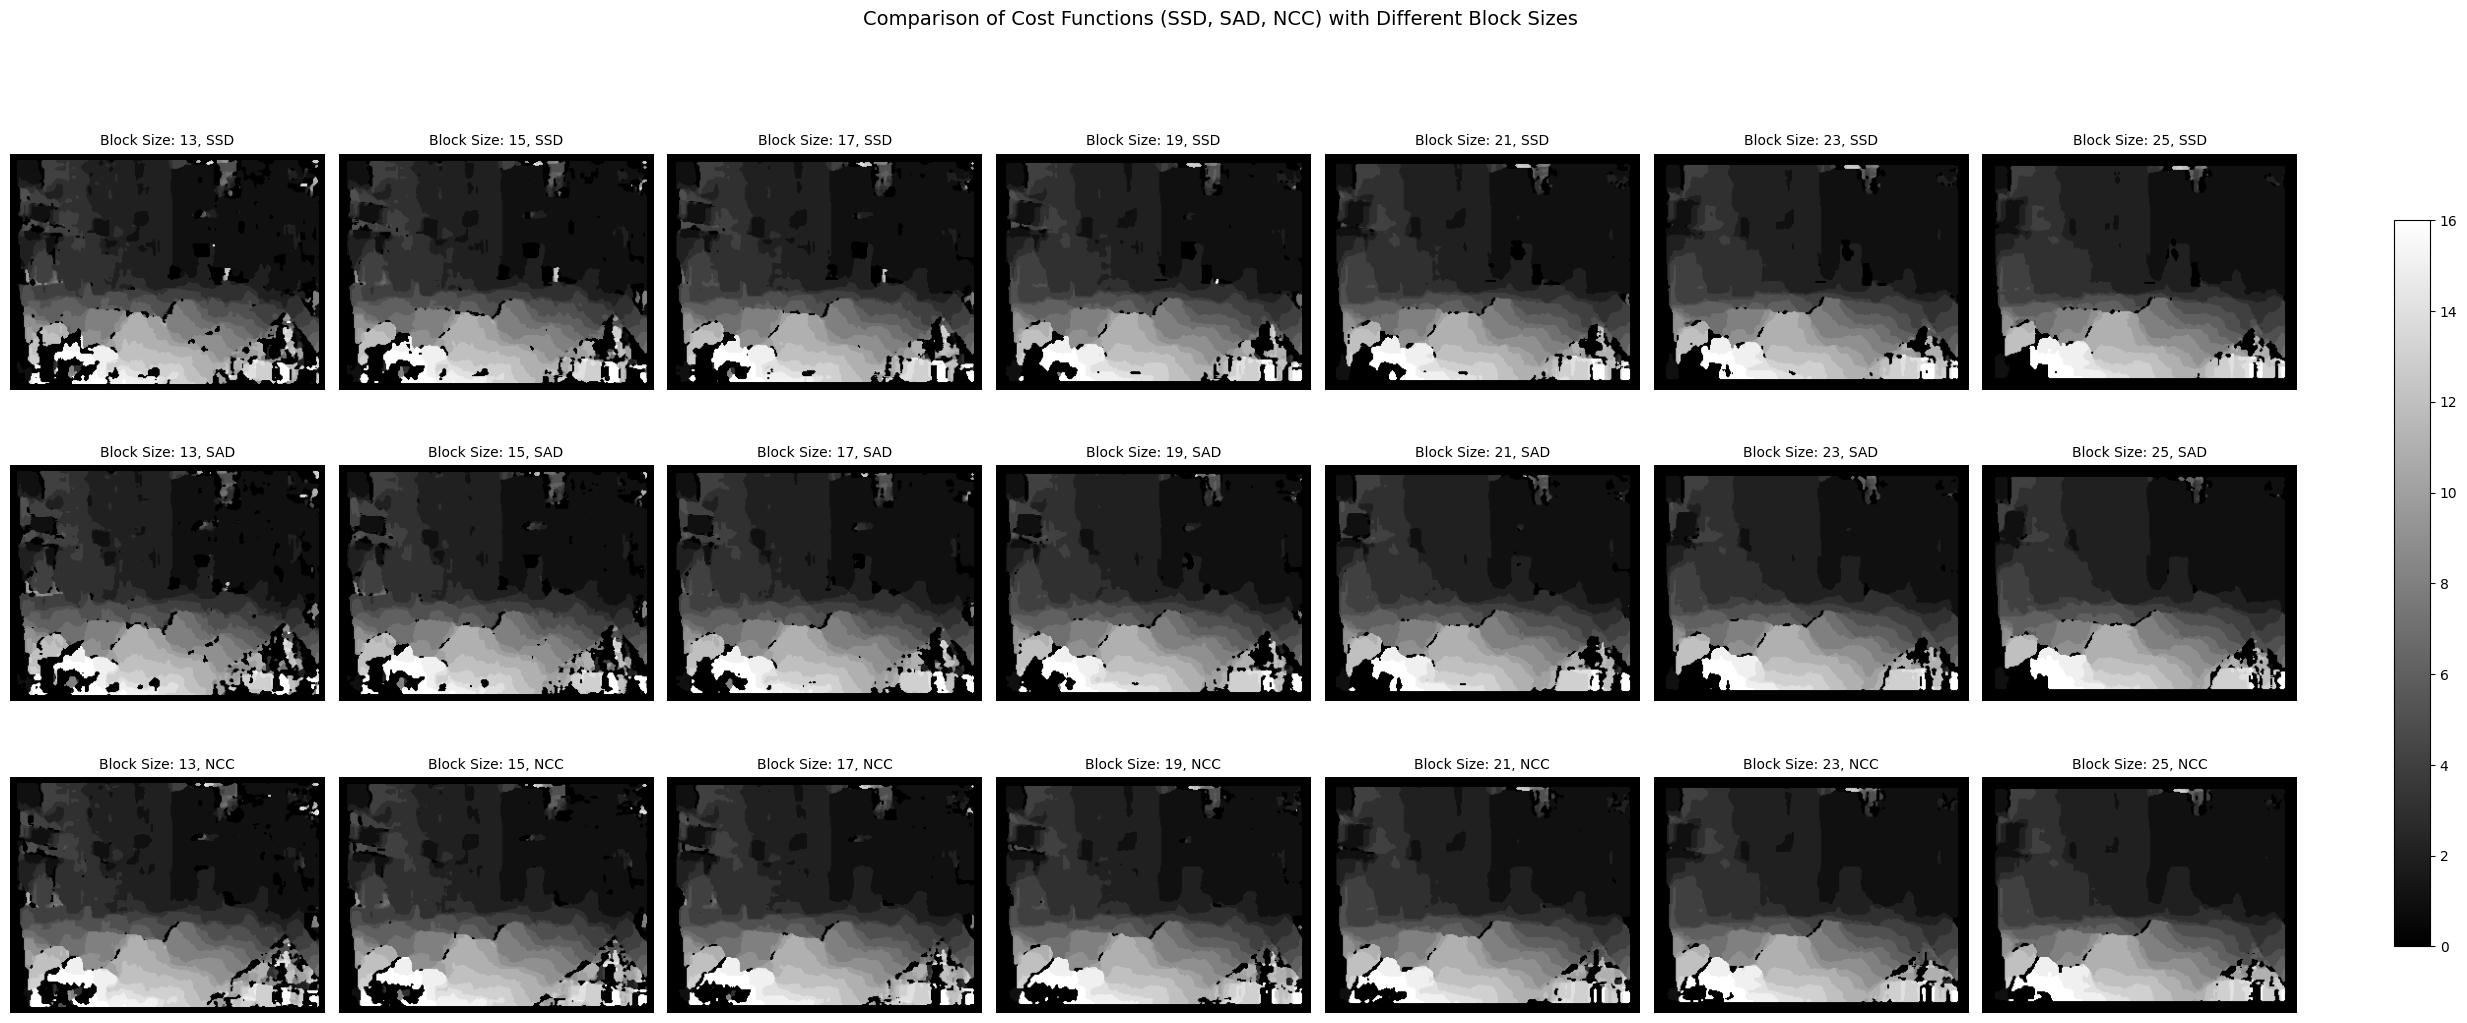

In [11]:
plot_cost_function_comparison(
    block_sizes = [i for i in range(13, 27, 2)],
    left_img_path="/content/triclopsi2l.jpg",
    right_img_path="/content/triclopsi2r.jpg",
    search_width=16,
    save_fig="cost_functions_triclopsi.png"
)

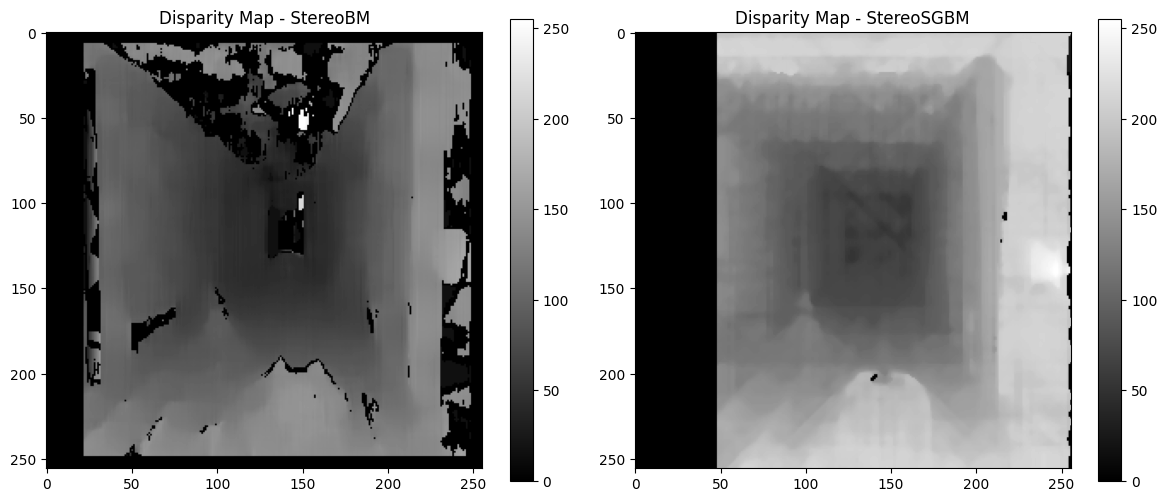

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load left and right images
left_img = cv2.imread('/content/corridorl.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('/content/corridorr.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images were loaded successfully
if left_img is None or right_img is None:
    print("Error loading images. Make sure 'left.png' and 'right.png' exist in the directory.")
    exit()

# Parameters for StereoBM
stereo_bm = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# Compute disparity map using StereoBM
disparity_bm = stereo_bm.compute(left_img, right_img)

# Normalize the disparity map for visualization
disparity_bm_norm = cv2.normalize(disparity_bm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_bm_norm = np.uint8(disparity_bm_norm)

# Parameters for StereoSGBM
min_disparity = 0
num_disparities = 16 * 3  # Should be multiple of 16
block_size = 5
stereo_sgbm = cv2.StereoSGBM_create(minDisparity=min_disparity,
                                    numDisparities=num_disparities,
                                    blockSize=block_size,
                                    P1=8 * 3 * block_size**2,
                                    P2=32 * 3 * block_size**2,
                                    disp12MaxDiff=1,
                                    uniquenessRatio=10,
                                    speckleWindowSize=100,
                                    speckleRange=32)

# Compute disparity map using StereoSGBM
disparity_sgbm = stereo_sgbm.compute(left_img, right_img)

# Normalize the disparity map for visualization
disparity_sgbm_norm = cv2.normalize(disparity_sgbm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_sgbm_norm = np.uint8(disparity_sgbm_norm)

# Display the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Disparity Map - StereoBM')
plt.imshow(disparity_bm_norm, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Disparity Map - StereoSGBM')
plt.imshow(disparity_sgbm_norm, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.savefig("corridor_bm.png", dpi=300)
plt.show()

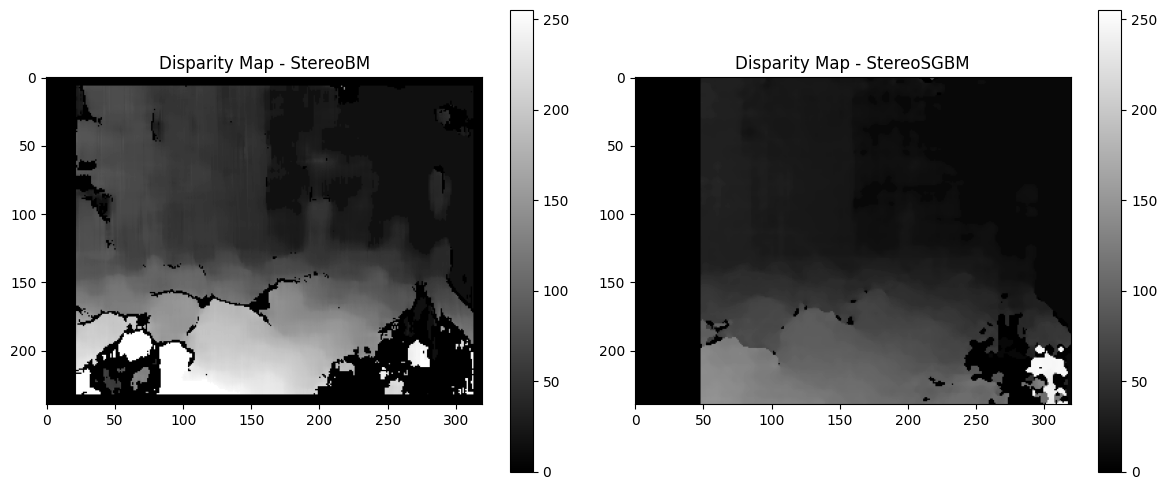

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

left_img = cv2.imread('/content/triclopsi2l.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('/content/triclopsi2r.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images were loaded successfully
if left_img is None or right_img is None:
    print("Error loading images. Make sure 'left.png' and 'right.png' exist in the directory.")
    exit()

# Parameters for StereoBM
stereo_bm = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# Compute disparity map using StereoBM
disparity_bm = stereo_bm.compute(left_img, right_img)

# Normalize the disparity map for visualization
disparity_bm_norm = cv2.normalize(disparity_bm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_bm_norm = np.uint8(disparity_bm_norm)

# Parameters for StereoSGBM
min_disparity = 0
num_disparities = 16 * 3  # Should be multiple of 16
block_size = 5
stereo_sgbm = cv2.StereoSGBM_create(minDisparity=min_disparity,
                                    numDisparities=num_disparities,
                                    blockSize=block_size,
                                    P1=8 * 3 * block_size**2,
                                    P2=32 * 3 * block_size**2,
                                    disp12MaxDiff=1,
                                    uniquenessRatio=10,
                                    speckleWindowSize=100,
                                    speckleRange=32)

# Compute disparity map using StereoSGBM
disparity_sgbm = stereo_sgbm.compute(left_img, right_img)

# Normalize the disparity map for visualization
disparity_sgbm_norm = cv2.normalize(disparity_sgbm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_sgbm_norm = np.uint8(disparity_sgbm_norm)

# Display the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Disparity Map - StereoBM')
plt.imshow(disparity_bm_norm, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Disparity Map - StereoSGBM')
plt.imshow(disparity_sgbm_norm, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.savefig("triclops_bm.png", dpi=300)
plt.show()